In [53]:
import pandas as pd
import numpy as np
from scipy.stats import (
    f_oneway, kruskal, shapiro, levene,
    mannwhitneyu
)
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns



config_time=pd.read_csv('/Users/shiyihe/Desktop/VIS_RESULT/0_task_time_config.csv')

In [54]:
config_time_only=config_time[['participantId','task','duration_sec','format']][config_time['task'] != 'unqualified']

def clean_time_data(df):

    df_cleaned = df.copy()
    
    # 按participantId分组计算总duration
    total_durations = df_cleaned.groupby('participantId')['duration_sec'].sum().reset_index()
    
    # 获取每个participant的format
    participant_formats = df_cleaned.groupby('participantId')['format'].first().reset_index()
    
    # 合并total duration和format
    total_data = total_durations.merge(participant_formats, on='participantId')
    
    # 创建只包含total行的数据框
    total_rows = []
    for _, row in total_data.iterrows():
        total_row = {
            'participantId': row['participantId'],
            'task': 'total',
            'duration_sec': row['duration_sec'],
            'format': row['format']
        }
        total_rows.append(total_row)
    
    # 只返回total行，不包含原始数据
    result_df = pd.DataFrame(total_rows)
    
    return result_df

config_time_clean=clean_time_data(config_time_only)

In [55]:
def compare_format_effect(df, method='anova', alpha=0.05):
    """
    比较每个 task 上 format 对 duration_sec 的影响。

    参数
    ----
    df : pandas.DataFrame
        必须包含 ['participantId','task','duration_sec','format']。
    method : {'anova','kruskal'}
        选择检验方法。anova 模式下会先对每个格式组做 Shapiro（正态性）和 Levene（方差齐性）检验，
        若不满足假设直接抛错；kruskal 模式下则做 Kruskal–Wallis 检验。
    alpha : float
        显著性水平，默认为 0.05。

    返回
    ----
    summary_df : DataFrame
        每个 task 的检验结果汇总，列 ['task','stat','p_value','test','signif']。
    posthoc_df : DataFrame
        所有显著 task 的两两事后比较，仅保留 reject==True（ANOVA 的 Tukey HSD 或 Kruskal 的 Mann-Whitney+Bonferroni）。
        ANOVA 模式下列 ['task','group1','group2','p-adj','reject']；
        Kruskal 模式下列 ['task','group1','group2','p_unc','p_adj','signif']。
    reg_tables : dict
        key=显著 task，value=statsmodels 拟合后 summary2().tables[1]（系数表，含星号列 'signif'）。
    """
    tasks = df['task'].unique()
    summary = []
    posthoc_list = []
    reg_tables = {}

    for task in tasks:
        sub = df[df['task'] == task]
        # 各格式的时长数组
        groups = [g['duration_sec'].values for _, g in sub.groupby('format')]
        formats = sub['format'].unique()
        if len(groups) < 2:
            continue  # 至少需要两个组才能比较

        test_name = method.upper()

        try:
            # ANOVA 模式：先做假设检验
            if method == 'anova':
                # 正态性检验（Shapiro）
                for fmt, d in sub.groupby('format')['duration_sec']:
                    if len(d) < 3:
                        raise ValueError(f"Task={task}, format={fmt} 样本量 {len(d)} < 3，无法做 Shapiro 正态性检验")
                    stat_s, p_s = shapiro(d)
                    if p_s < alpha:
                        raise ValueError(f"Task={task}, format={fmt} Shapiro p={p_s:.3f} < {alpha}，不满足正态性")
                # 方差齐性检验（Levene）
                stat_l, p_l = levene(*groups)
                if p_l < alpha:
                    raise ValueError(f"Task={task} Levene p={p_l:.3f} < {alpha}，不满足方差齐性")

                # 一元 ANOVA
                f_stat, p_val = f_oneway(*groups)
                stat, p = f_stat, p_val

            # Kruskal–Wallis 模式
            elif method == 'kruskal':
                h_stat, p_val = kruskal(*groups)
                stat, p = h_stat, p_val

            else:
                raise ValueError("method 必须为 'anova' 或 'kruskal'")

            # 星号标记
            signif = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''

            summary.append({
                'task': task,
                'stat': stat,
                'p_value': p,
                'test': test_name,
                'signif': signif
            })

            # 若显著，则做事后检验 & 回归
            if p < alpha:
                # —— 事后比较 —— #
                if method == 'anova':
                    tukey = pairwise_tukeyhsd(
                        endog=sub['duration_sec'],
                        groups=sub['format'],
                        alpha=alpha
                    )
                    df_tukey = pd.DataFrame(
                        data=tukey.summary().data[1:],
                        columns=tukey.summary().data[0]
                    )
                    sig_tukey = df_tukey[df_tukey['reject'] == True].copy()
                    sig_tukey['task'] = task
                    posthoc_list.append(sig_tukey[['task','group1','group2','p-adj','reject']])

                else:  # kruskal
                    m = len(formats)
                    n_pairs = m*(m-1)/2
                    pairs = []
                    for f1, f2 in combinations(formats, 2):
                        d1 = sub[sub['format']==f1]['duration_sec']
                        d2 = sub[sub['format']==f2]['duration_sec']
                        u_stat, p_u = mannwhitneyu(d1, d2, alternative='two-sided')
                        p_adj = min(p_u * n_pairs, 1.0)
                        if p_adj < alpha:
                            pairs.append({
                                'task': task,
                                'group1': f1,
                                'group2': f2,
                                'p_unc': p_u,
                                'p_adj': p_adj,
                                'signif': '*' 
                            })
                    if pairs:
                        posthoc_list.append(pd.DataFrame(pairs))

                # —— 回归模型 —— #
                model = ols('duration_sec ~ C(format)', data=sub).fit()
                tbl = model.summary2().tables[1].copy()
                # 增加星号列
                tbl['signif'] = tbl['P>|t|'].apply(
                    lambda x: '***' if x<0.001 else '**' if x<0.01 else '*' if x<0.05 else ''
                )
                reg_tables[task] = tbl

        except ValueError as err:
            # 抛给调用者，让调用者决定切换到 kruskal
            raise

    summary_df = pd.DataFrame(summary)
    posthoc_df = pd.concat(posthoc_list, ignore_index=True) if posthoc_list else pd.DataFrame()
    return summary_df, posthoc_df, reg_tables


summary_df, posthoc_df, reg_tables = compare_format_effect(
    config_time_clean,
    method='kruskal',    # 或 'kruskal'
    alpha=0.05
)

# 1) 汇总结果
summary_df
#   task    stat      p_value   test   signif
# 0  intro  3.45     0.032     ANOVA    *
# 1  ...    ...      ...       ...      ...

# 2) 两两事后显著比较
# print(posthoc_df)
#    task    group1   group2   p-adj   reject
# 0  intro    json     xml      0.02    True
# ...

# 3) 回归表（仅显著的 task）
# for task, tbl in reg_tables.items():
    # print(f"=== Regression for task: {task} ===")
    # print(tbl)
    # tbl 已包含 Coef.、Std.Err.、t、P>|t|、[0.025 0.975]、signif 列

,task,stat,p_value,test,signif
0,total,3.523328,0.740863,KRUSKAL,


In [46]:
def generate_regression_tables_with_baseline(
    df: pd.DataFrame,
    task_list: list,
    baseline: str = 'hjson',
    participant_col: str = 'participantId',
    value_col: str = 'duration_sec',
    group_col: str = 'format',
    subtask_col: str = 'task'
) -> dict:
    """
    为每个 task 拟合 duration_sec ~ C(format)，使 baseline 作为 Intercept，
    并输出和参考图一致的回归系数表（含显著星号）。

    参数
    ----
    df : DataFrame
      原始数据，需包含 [participant_col, subtask_col, value_col, group_col]
    task_list : list of str
      要生成回归表的任务名列表（可含 'total'）
    baseline : str
      指定哪个 format 做为基准组（Intercept）
    """
    reg_tables = {}

    for task in task_list:
        # 1) 准备数据
        if task == 'total':
            data = (
                df
                .groupby([participant_col, group_col])[value_col]
                .sum()
                .reset_index()
            )
        else:
            data = df[df[subtask_col] == task].copy()

        # 2) 把 format 设为 categorical，并重排 baseline 到第一位
        data[group_col] = data[group_col].astype('category')
        cats = list(data[group_col].cat.categories)
        if baseline not in cats:
            raise ValueError(f"baseline '{baseline}' 不在 {group_col} 的类别 {cats} 中")
        new_order = [baseline] + [c for c in cats if c != baseline]
        data[group_col] = data[group_col].cat.reorder_categories(new_order)

        # 3) 拟合模型：Intercept 就是 baseline 的均值
        formula = f"{value_col} ~ C({group_col})"
        model = ols(formula, data=data).fit()

        # 4) 提取系数表并整理
        tbl = model.summary2().tables[1].reset_index().rename(columns={'index': 'term'})
        # 重命名 Intercept
        tbl.loc[tbl['term'] == 'Intercept', 'term'] = f"Baseline ({baseline})"
        # 增加显著性星号
        tbl['signif'] = tbl['P>|t|'].apply(
            lambda p: '***' if p<0.001 else '**' if p<0.01 else '*' if p<0.05 else ''
        )

        # 5) 只保留并排好列
        cols = ['term', 'Coef.', 'Std.Err.', 't', 'P>|t|', '[0.025', '0.975]', 'signif']
        reg_tables[task] = tbl[cols]

    return reg_tables




# 假设你已经有 config_time_only, summary_df, posthoc_df
tasks = ['total']
reg_tables = generate_regression_tables_with_baseline(
    config_time_clean,
    task_list=tasks,
    baseline='hjson',
    participant_col='participantId',
    value_col='duration_sec',
    group_col='format',
    subtask_col='task'
)

# 查看 total 任务的回归表
reg_tables['total']



,term,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],signif
0,Baseline (hjson),3612.013000,294.000331,12.285745,1.071536e-21,3028.724717,4195.301283,***
1,C(format)[T.json],-41.320529,409.619222,-0.100875,9.198513e-01,-853.993400,771.352341,
2,C(format)[T.json5],-276.829667,422.652105,-0.654982,5.139829e-01,-1115.359406,561.700073,
3,C(format)[T.jsonc],-275.815467,422.652105,-0.652583,5.155227e-01,-1114.345206,562.714273,
4,C(format)[T.toml],-636.945867,422.652105,-1.507022,1.349577e-01,-1475.475606,201.583873,
5,C(format)[T.xml],-425.059143,430.372417,-0.987654,3.257057e-01,-1278.905760,428.787474,
6,C(format)[T.yaml],53.708533,422.652105,0.127075,8.991362e-01,-784.821206,892.238273,


/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_72499/1819041222.py:188: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figures['total'].show()


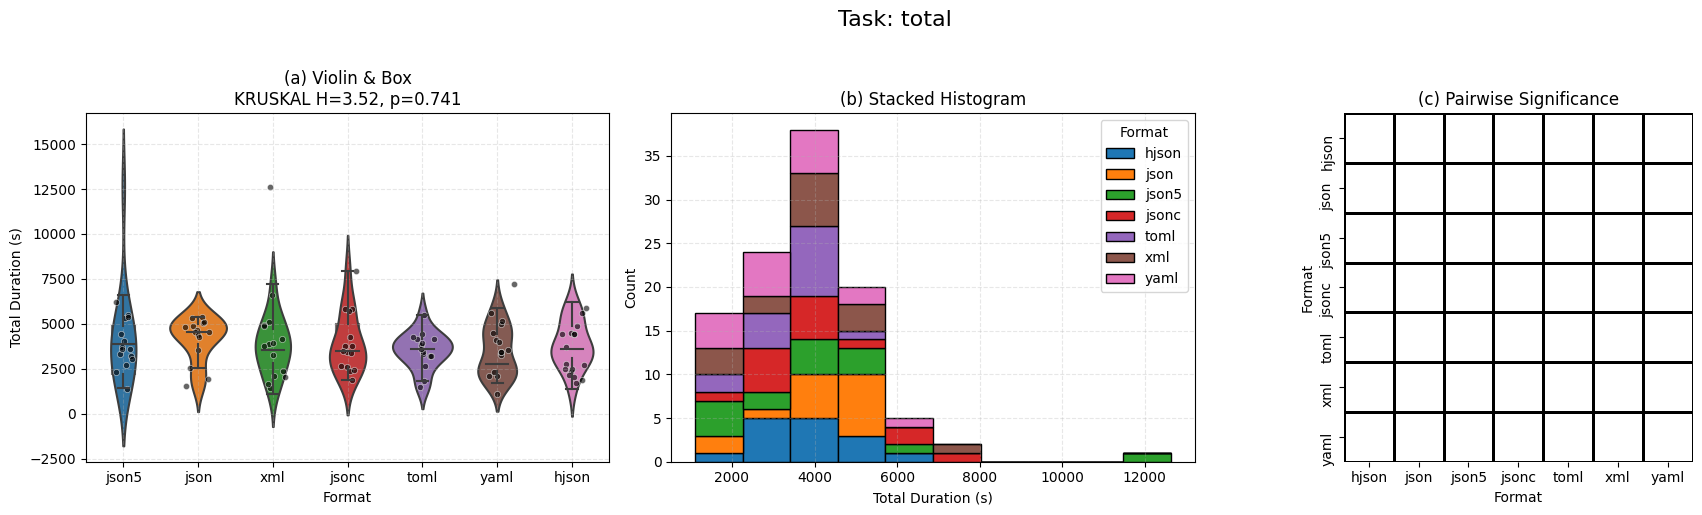

In [61]:

def plot_format_differences_by_task(
    df: pd.DataFrame,
    compare_res: dict,
    task_list: list,
    participant_col: str = 'participantId',
    value_col: str = 'duration_sec',
    group_col: str = 'format',
    subtask_col: str = 'task',
    alpha: float = 0.05,
    palette: list = None
) -> dict:
    """
    为 task_list 中的每个任务绘制三联图：
      (a) 小提琴+箱线+散点 + 全局检验信息
      (b) 堆叠直方图
      (c) 格式×格式 事后检验星号热图

    参数
    ----
    df : DataFrame
        原始数据，需包含 [participant_col, subtask_col, value_col, group_col]
    compare_res : dict
        {
          'global_df': DataFrame,  # 包含列 ['task','stat','p_value','test','signif']
          'posthoc': DataFrame 或 dict
             如果是 DataFrame，需包含 ['task','group1','group2','p-adj' 或 'p_adj']。
             如果是 dict，则应直接是 { task_name: posthoc_df_for_that_task }
        }
    task_list : list of str
        你想要可视化的任务名列表，比如 ['total','writing-task-NL']
    alpha : float
        显著性水平
    palette : list, optional
        seaborn 调色板列表

    返回
    ----
    figs : dict
        key=任务名, value=对应的 matplotlib.Figure
    """
    # 所有可能的格式
    formats = sorted(df[group_col].unique().tolist())
    if palette is None:
        palette = sns.color_palette("tab10", n_colors=len(formats))

    global_df = compare_res['global_df']
    posthoc_input = compare_res.get('posthoc', pd.DataFrame())

    figs = {}
    for task in task_list:
        # ---- 1) 准备数据 ----
        if task == 'total':
            data = (
                df
                .groupby([participant_col, group_col])[value_col]
                .sum()
                .reset_index()
            )
            ylabel = 'Total Duration (s)'
        else:
            data = df[df[subtask_col] == task]
            ylabel = 'Duration (s)'

        # ---- 2) 全局检验信息 ----
        row = global_df[global_df['task'] == task]
        if not row.empty:
            row = row.iloc[0]
            stat_name = 'H' if row['test'].lower().startswith('kruskal') else 'F'
            stat_val  = row['stat']
            pval      = row['p_value']
            stars     = row.get('signif', '') or (
                '***' if pval<0.001 else '**' if pval<0.01 else '*' if pval<0.05 else ''
            )
            test_label = f"{row['test']} {stat_name}={stat_val:.2f}, p={pval:.3f}{stars}"
        else:
            test_label = "No global test"

        # ---- 3) 针对本 task 筛 posthoc ----
        if isinstance(posthoc_input, dict):
            post_df = posthoc_input.get(task, pd.DataFrame())
        else:
            
            # DataFrame 情形，先检查列
            if 'task' in posthoc_input.columns:
                post_df = posthoc_input[posthoc_input['task'] == task]
            else:
                post_df = pd.DataFrame()

        # build star matrix
        star_mat = pd.DataFrame('', index=formats, columns=formats)
        if not post_df.empty:
            pcol = 'p-adj' if 'p-adj' in post_df.columns else 'p_adj'
            for _, r in post_df.iterrows():
                g1, g2 = r['group1'], r['group2']
                p_pair = r[pcol]
                s = '***' if p_pair<0.001 else '**' if p_pair<0.01 else '*' if p_pair<0.05 else ''
                star_mat.loc[g1, g2] = s
                star_mat.loc[g2, g1] = s

        # ---- 4) 开始绘图 ----
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f"Task: {task}", fontsize=16, y=1.02)

        # (a) Violin + Box + Scatter
        ax1 = axes[0]
        sns.violinplot(
            data=data, x=group_col, y=value_col,
            palette=palette, violin_kws = {'alpha': 0.3}, inner=None, ax=ax1
        )
        sns.boxplot(
            data=data, x=group_col, y=value_col,
            palette=palette, width=0.3, boxprops={'alpha':0.7},
            showfliers=False, ax=ax1
        )
        for i, fmt in enumerate(formats):
            vs = data.loc[data[group_col] == fmt, value_col]
            jitter_x = np.random.normal(i, 0.08, size=len(vs))
            ax1.scatter(jitter_x, vs,
                        color='black', s=20, alpha=0.6,
                        edgecolors='white', linewidth=0.5)
        ax1.set_title("(a) Violin & Box\n" + test_label, fontsize=12)
        ax1.set_xlabel("Format"); ax1.set_ylabel(ylabel)
        ax1.grid(True, linestyle='--', alpha=0.3)

        # (b) Stacked Histogram
        ax2 = axes[1]
        bins = 10
        vals = [data.loc[data[group_col] == fmt, value_col] for fmt in formats]
        ax2.hist(vals, bins=bins,
                 stacked=True,
                 label=formats,
                 color=palette,
                 edgecolor='black')
        ax2.set_title("(b) Stacked Histogram", fontsize=12)
        ax2.set_xlabel(ylabel); ax2.set_ylabel("Count")
        ax2.legend(title="Format")
        ax2.grid(True, linestyle='--', alpha=0.3)

        # (c) Pairwise Significance Heatmap
        ax3 = axes[2]
        sns.heatmap(
            np.zeros((len(formats), len(formats))),
            annot=star_mat.values,
            fmt='',
            cmap='Greys',
            cbar=False,
            linewidths=1,
            linecolor='black',
            xticklabels=formats,
            yticklabels=formats,
            square=True,
            ax=ax3
        )
        ax3.set_title("(c) Pairwise Significance", fontsize=12)
        ax3.set_xlabel("Format"); ax3.set_ylabel("Format")

        plt.tight_layout()
        figs[task] = fig

    return figs



# 假设你已有 compare_format_effect 输出的两个 DataFrame：
#   summary_df, posthoc_df
compare_res = {
    'global_df': summary_df,
    'posthoc': posthoc_df  # 或者你自己整理好的 { task_name: df_task }
}

# 明确传入你要画的任务列表
tasks_to_draw = ['total']
# base = sns.color_palette("tab10", 7)
# palette = [(r, g, b, 0.3) for r, g, b in base]

figures = plot_format_differences_by_task(
    config_time_clean,
    compare_res,
    task_list=tasks_to_draw,
    participant_col='participantId',
    value_col='duration_sec',
    group_col='format',
    subtask_col='task',
    alpha=0.05
)

# 显示或保存
figures['total'].show()
# figures['writing-task-NL'].savefig("writing_NL.png")



In [9]:
config_time_clean[config_time_clean['format']=='json5']

,participantId,task,duration_sec,format
0,5755c957eb80c4000741a9ce,total,1422.986,json5
8,5ea90bb434d5e337e98c7edd,total,5117.160,json5
10,5f7f239e9b204e05b6c36538,total,3907.764,json5
18,60ec51c51a3158a50ded8a3e,total,2084.882,json5
35,65e85a421f2dee53c62fbf45,total,12630.016,json5
36,65f4ab7884f8411c9e11a34e,total,2390.894,json5
44,6647e8618c77f7b938865d25,total,3276.581,json5
48,666b0b42bb6fa2822fa27a32,total,3775.952,json5
55,6693d3ae2bd15cf7a058e6a7,total,4922.310,json5
71,674f479b2a4ef75e4551f258,total,4856.309,json5


In [24]:
mask_others = (
    (config_time_only['task'] == 'tutorial-part1') &
    (config_time_only['participantId'] != '65e85a421f2dee53c62fbf45')
)
mean_duration = config_time_only.loc[mask_others, 'duration_sec'].mean()
print(mean_duration)

idxs = config_time_only.query("task=='tutorial-part1' and participantId=='65e85a421f2dee53c62fbf45'").index
config_time_only.loc[idxs, 'duration_sec'] = mean_duration


457.84000943396234


,participantId,task,duration_sec,format
0,67895b7d6400163124042af7,introduction,395.748,jsonc
1,67895b7d6400163124042af7,qualifications,10.282,jsonc
2,67895b7d6400163124042af7,consent,63.068,jsonc
3,67895b7d6400163124042af7,task,14.610,jsonc
4,67895b7d6400163124042af7,writing-task-NL,475.830,jsonc
...,...,...,...,...
3311,5c4f5967aac8be0001716a65,modifying-task-config-3_post-task-question,2.921,xml
3312,5c4f5967aac8be0001716a65,modifying-task-config-4,499.679,xml
3313,5c4f5967aac8be0001716a65,modifying-task-config-4_post-task-question,4.825,xml
3314,5c4f5967aac8be0001716a65,$nasa-tlx.co.nasa-tlx,23.666,xml
